<a id=top-page></a>
# `pykitPIV` demo: Setup a reinforcement learning environment for a virtual particle image velocimetry (PIV) setup

In this Jupyter notebook, we show how a 2D virtual wind tunnel environment can be initialized for reinforcement learning.


<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#specs">Prepare specifications for <code>pykitPIV</code> parameters </a></li>
    <li><a href="#PIVEnv-create">Create the RL environment</a></li>
    <li><a href="#PIVEnv-render">Rendering the environment</a></li>
    <li><a href="#PIVEnv-step">Stepping in the environment</a></li>
</ol>
<p></p>
</div>
<br>

***

In [1]:
from pykitPIV.ml import PIVEnv, Rewards, Cues, plot_trajectory
from pykitPIV.flowfield import compute_q_criterion, compute_divergence, compute_vorticity
from pykitPIV import ParticleSpecs, FlowFieldSpecs, MotionSpecs, ImageSpecs
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import numpy as np
import onnxruntime
import sys, os
import time

2025-05-15 13:33:23.492674: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
save_images = False
filename = None

In [3]:
interrogation_window_size = (60,60)
interrogation_window_size_buffer = 10

<a id=specs></a>
***

## Prepare specifications for `pykitPIV` parameters 

[Go to the top](#top-page)

Specifications can be dictionaries or objects of the appropriate configuration classes from pykitPIV.
Below, we create both examples. 

Let's start with dictionaries:

In [4]:
particle_spec = {'diameters': (1, 1),
                 'distances': (2, 2),
                 'densities': (0.4, 0.4),
                 'diameter_std': 1,
                 'seeding_mode': 'random'}

flowfield_spec = {'size': (200, 500),
                  'time_separation': 2,
                  'flowfield_type': 'random smooth',
                  'gaussian_filters': (10, 10),
                  'n_gaussian_filter_iter': 10,
                  'displacement': (2, 2)}

motion_spec = {'n_steps': 10,
               'particle_loss': (0, 0),
               'particle_gain': (0, 0)}

image_spec = {'exposures': (0.98, 0.98),
              'maximum_intensity': 2**16-1,
              'laser_beam_thickness': 1,
              'laser_over_exposure': 1,
              'laser_beam_shape': 0.95,
              'alpha': 1/8,
              'clip_intensities': True,
              'normalize_intensities': False}

Otherwise, specifications can be objects of the appropriate configuration classes:

In [5]:
particle_spec = ParticleSpecs(diameters=(1, 1),
                              distances=(2, 2),
                              densities=(0.4, 0.4),
                              diameter_std=1,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=(1, 1),
distances=(2, 2),
densities=(0.4, 0.4),
diameter_std=1,
seeding_mode='random',
dtype=<class 'numpy.float64'>,
random_seed=None)


In [6]:
flowfield_spec = FlowFieldSpecs(size=(200, 500), 
                                time_separation=2,
                                flowfield_type='random smooth',
                                gaussian_filters=(10, 10),
                                n_gaussian_filter_iter=10,
                                displacement=(2, 2))

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(200, 500),
size_buffer=10,
time_separation=2,
random_seed=None,
flowfield_type='random smooth',
gaussian_filters=(10, 10),
n_gaussian_filter_iter=10,
displacement=(2, 2),
radial_source=True,
radial_imposed_source_location=None,
radial_sigma=20,
radial_epsilon=1e-06,
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100)


In [7]:
motion_spec = MotionSpecs(n_steps=10,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
n_steps=10,
particle_loss=(0, 0),
particle_gain=(0, 0),
random_seed=None)


In [8]:
image_spec = ImageSpecs(exposures=(0.98, 0.98),
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=(0.98, 0.98),
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
no_laser_plane=False,
alpha=0.125,
extend_gaussian=1,
covariance_matrix=None,
clip_intensities=True,
normalize_intensities=False)


Use LIMA as an inference model:

In [9]:
class ONNXmodel:
    
    def __init__(self,
                 onnx_file_path):
        
        self.name = "ONNX"
        self.providers = ['CPUExecutionProvider']
        self.session = onnxruntime.InferenceSession(onnx_file_path, 
                                                    None,
                                                    providers=self.providers)

        self.input_name = self.session.get_inputs()[0].name  
        print('Input Name:', self.input_name)   
 
    def inference(self, x):
        
        output = self.session.run([], {self.input_name:x/np.max(x)})[0] 
      
        return output

    def empty(self):
        
         with torch.no_grad():
            torch.cuda.empty_cache()

In [10]:
model_file = '../Lima_L4_PAD_SR2_dyn.onnx'
print("model:", model_file, '  exist:', os.path.exists(model_file))

model: ../Lima_L4_PAD_SR2_dyn.onnx   exist: True


In [11]:
lima_inference_model = ONNXmodel(model_file)

Input Name: Input


<a id=PIVEnv-create></a>

***

## Create the RL environment

[Go to the top](#top-page)

Define the cues that the RL agent effectively senses and learns from:

In [12]:
def cues_function(displacement_field_tensor):

    mean_displacement = np.mean(displacement_field_tensor)
    max_displacement = np.max(displacement_field_tensor)
    min_displacement = np.min(displacement_field_tensor)
    
    cues = np.array([[mean_displacement, max_displacement, min_displacement]])

    return cues

**pykitPIV** provides the ``PIVEnv`` class that is a subclass of the ``gymnasium.Env`` class.
This class implements the reinforcement learning (RL) environment and provides a virtual PIV/BOS setup
for the RL agent to interact with. The RL agent has the ability to interact with any of the **pykitPIV** parameters.
This class can be readily accessed from the ``ml`` module.

Initialize the `Gymnasium` environment:

In [13]:
env = PIVEnv(interrogation_window_size=interrogation_window_size,
             interrogation_window_size_buffer=interrogation_window_size_buffer,
             cues_function=cues_function,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=flowfield_spec,
             user_flowfield=None,
             inference_model=lima_inference_model,
             random_seed=None)

We first reset the environment to create the first starting position for the interrogation window that the virtual PIV camera is centered at.

The user can `reset()` the environment to a randomly assigned position:

In [14]:
camera_position, cues = env.reset()

Or to an imposed position, say 75px along the height and 50px along the width of the virtual wind tunnel:

In [15]:
camera_position, cues = env.reset(imposed_camera_position=(75,50))

<a id=PIVEnv-render></a>

***

## Rendering the environment

[Go to the top](#top-page)

Without specifying the quantity to plot, the function `render()` visualizes the displacement field magnitude, $|d \vec{\mathbf{s}}|$. It also 

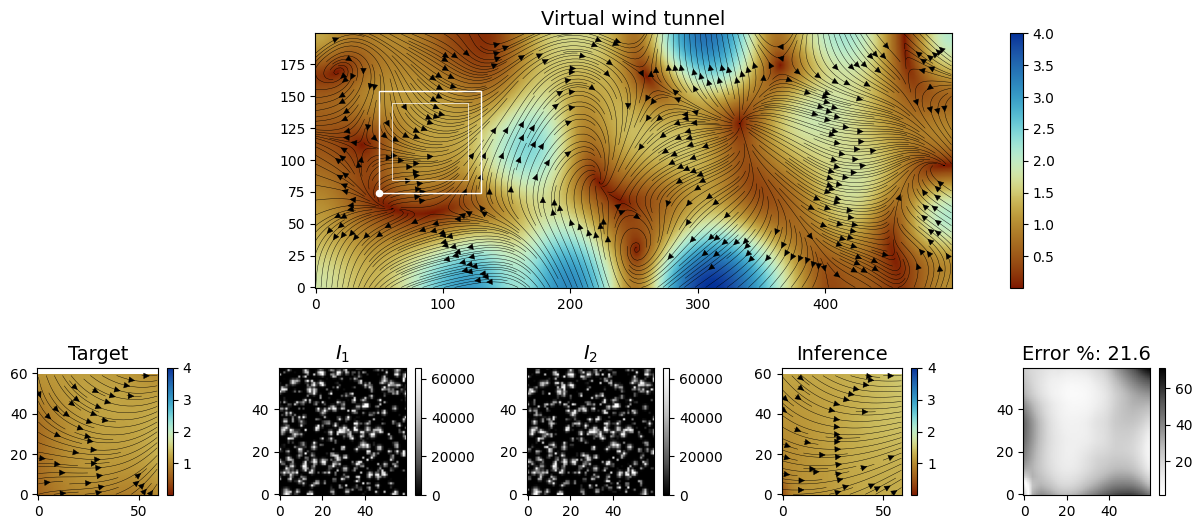

In [16]:
if save_images: filename = 'PIVEnv-virtual-wind-tunnel-ds-magnitude.png'
plt = env.render(quantity=None,
                 camera_position=camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=4,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(15,6), 
                 filename=filename)

If the user is only interested in visualizing the flow field in the virtual wind tunnel, we can switch off plotting of the camera position (`camera_position = False`) and switch off plotting the PIV details under the interrogation window (`wind_tunnel_only = True`).

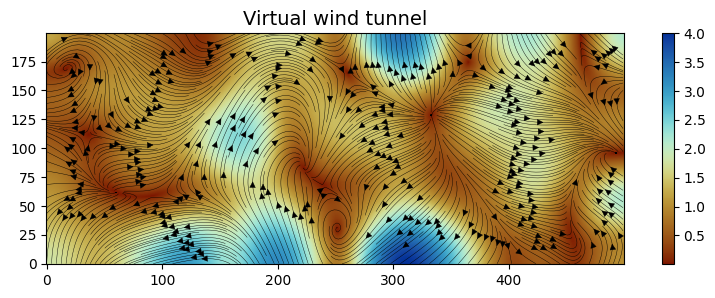

In [17]:
if save_images: filename = 'PIVEnv-virtual-wind-tunnel-ds-magnitude-wt-only.png'
plt = env.render(quantity=None,
                 camera_position=None,
                 wind_tunnel_only=True,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=4,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,3), 
                 filename=filename)

We can also specify a different quantity to plot in the virtual wind tunnel. It can be, for example, the velocity field magnitude:

In [18]:
quantity = env.flowfield.velocity_field_magnitude[0,0,:,:]
quantity.shape

(200, 500)

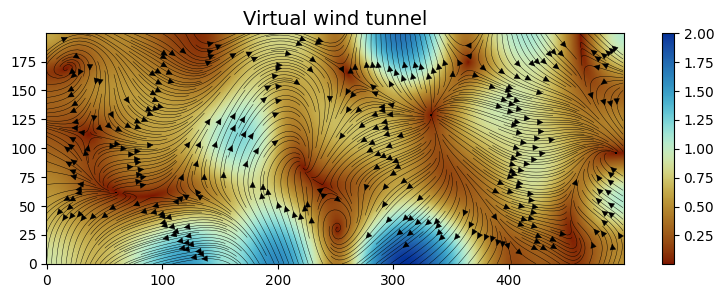

In [19]:
if save_images: filename = 'PIVEnv-virtual-wind-tunnel-velocity-magnitude.png'
plt = env.render(quantity=quantity,
                 camera_position=None,
                 wind_tunnel_only=True,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=4,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,3), 
                 filename=filename)

In this case, since the time separation, $\Delta t$, between image frames is 2, the maximum displacement field magnitude is 4, whereas the maximum velocity field is magnitude. This follows from $d\vec{\mathbf{s}} = [dx, dy] = [u \Delta t, v \Delta t]$.

The plotted quantity can also be the learned policy computed after training the RL agent. This helps visualize the quality of training.

Alternatively, one can also plot various characteristics of the velocity field in the virtual wind tunnel, such as the divergence, vorticity, or the Q-criterion.

Here's the example of visualizing the Q-criterion, which can help locate vortices:

In [20]:
q_criterion = compute_q_criterion(env.flowfield.velocity_field, edge_order=1)[0,:,:]
q_criterion.shape

(200, 500)

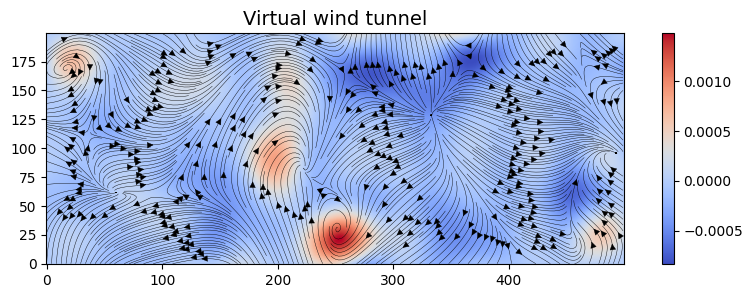

In [21]:
if save_images: filename = 'PIVEnv-virtual-wind-tunnel-Q-criterion.png'
plt = env.render(quantity=q_criterion,
                 camera_position=None,
                 wind_tunnel_only=True,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=False,
                 cmap='coolwarm',
                 add_streamplot=True,
                 streamplot_density=4,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,3), 
                 filename=filename)

Here's another example of visualizing the divergence:

In [22]:
divergence = compute_divergence(env.flowfield.velocity_field, edge_order=1)[0,:,:]
divergence.shape

(200, 500)

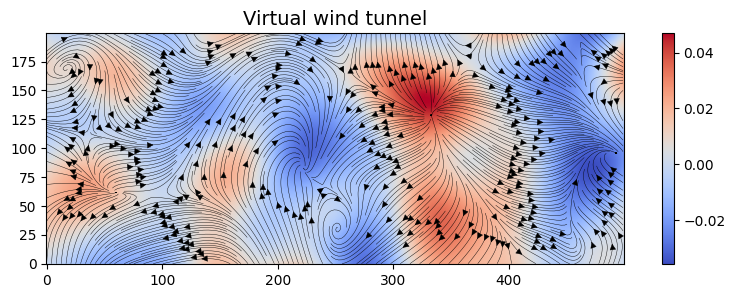

In [23]:
if save_images: filename = 'PIVEnv-virtual-wind-tunnel-divergence.png'
plt = env.render(quantity=divergence,
                 camera_position=None,
                 wind_tunnel_only=True,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=False,
                 cmap='coolwarm',
                 add_streamplot=True,
                 streamplot_density=4,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,3), 
                 filename=filename)

<a id=PIVEnv-step></a>

***

## Stepping in the environment

[Go to the top](#top-page)

Below, we test taking steps in the environment. Each step moves the virtual PIV camera to a new interrogation window.
Under each new window, the agent sees the new displacement field, and hence the new sensory cues computed directly from the displacement field.
Based on the sensory cues, a numerical value for the reward, $R$, is computed.

First, we need to construct the reward function, along with the reward function transformation that computes the single numerical value, $R$. We will use the maximum Q-cirterion value.

In [24]:
rewards = Rewards(verbose=False)
reward_function = rewards.q_criterion

In [25]:
def reward_transformation(Q):
    Q = np.max(Q.clip(min=0))
    return Q

We reset the environment to some fixed initial state:

In [26]:
camera_position, cues = env.reset(imposed_camera_position=(50,200))

We can render the initial camera position:

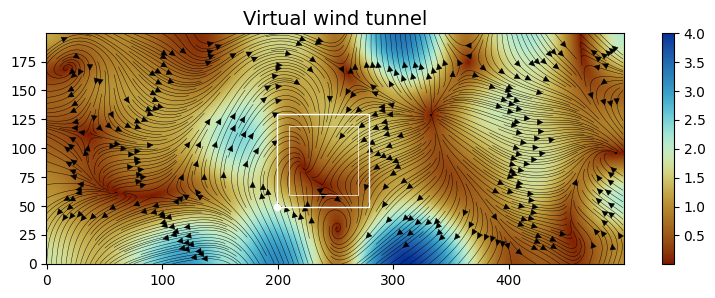

In [27]:
if save_images: filename = 'PIVEnv-stepping-initial-camera-position.png'
plt = env.render(quantity=None,
                 camera_position=camera_position,
                 wind_tunnel_only=True,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=4,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,3), 
                 filename=filename)

First, we take 5 steps, each time printing the verbose information and rendering the environment. We amplify the step taken by the factor of 10, i.e., each time an agent moves the camera, it moves by 10px.

In [28]:
actions = [0, 0, 0, 1, 1]

In [29]:
for i in range(0,5):

    camera_position, cues, reward = env.step(actions[i], 
                                             reward_function=reward_function,
                                             reward_transformation=reward_transformation,
                                             magnify_step=10,
                                             verbose=True)    

    print()

Action 0: Up
Camera position:
[ 60 200]
Cues:
[[-0.43653387  0.66671467 -1.268663  ]]
Reward:
0.00029199602

Action 0: Up
Camera position:
[ 70 200]
Cues:
[[-0.44686103  0.85962117 -1.2045532 ]]
Reward:
0.0004417717

Action 0: Up
Camera position:
[ 80 200]
Cues:
[[-0.55544597  0.96028894 -1.3924503 ]]
Reward:
0.0014019578

Action 1: Right
Camera position:
[ 80 210]
Cues:
[[-0.7242747   0.32509774 -1.4246762 ]]
Reward:
0.00016526492

Action 1: Right
Camera position:
[ 80 220]
Cues:
[[-0.7949323  0.2783075 -1.3847886]]
Reward:
0.01675288



There is a more efficient way of rendering the movement of the camera using the function ``pykitPIV.ml.plot_trajectory()``

In [48]:
camera_position, cues = env.reset(imposed_camera_position=(50,200))

In [49]:
actions = [3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0]

In [50]:
n_steps = len(actions)

In [51]:
trajectory = np.zeros((n_steps+1,2))
trajectory[0, 0] = camera_position[0]
trajectory[0, 1] = camera_position[1]

for i in range(0,n_steps):

    camera_position, cues, reward = env.step(actions[i], 
                                             reward_function=reward_function,
                                             reward_transformation=reward_transformation,
                                             magnify_step=10,
                                             verbose=False)    

    trajectory[i+1, 0] = camera_position[0]
    trajectory[i+1, 1] = camera_position[1]

The trajectory vector is a set of 2D camera positions:

In [52]:
trajectory

array([[ 50., 200.],
       [ 50., 190.],
       [ 50., 180.],
       [ 50., 170.],
       [ 50., 160.],
       [ 50., 150.],
       [ 50., 140.],
       [ 50., 130.],
       [ 50., 120.],
       [ 50., 110.],
       [ 50., 100.],
       [ 50.,  90.],
       [ 50.,  80.],
       [ 60.,  80.],
       [ 70.,  80.],
       [ 80.,  80.],
       [ 90.,  80.],
       [100.,  80.],
       [110.,  80.],
       [120.,  80.],
       [120.,  80.],
       [120.,  80.]])

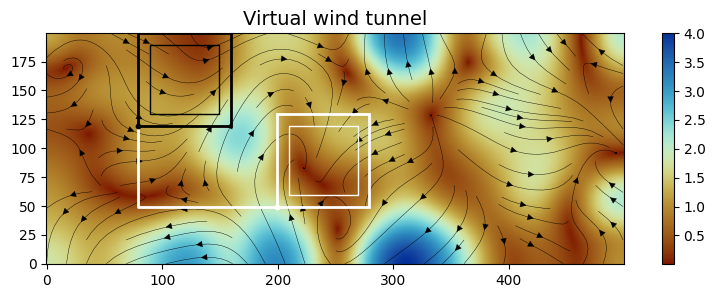

In [53]:
plot_trajectory(trajectory=trajectory,
                quantity=env.flowfield.displacement_field_magnitude[0,0,:,:],
                vector_field=env.flowfield.displacement_field,
                interrogation_window_size=interrogation_window_size,
                interrogation_window_size_buffer=interrogation_window_size_buffer,
                c_path='white',
                c_init='white',
                c_final='black',
                s=10,
                lw=2,
                cmap=cmc.roma,
                add_streamplot=True,
                streamplot_density=1,
                streamplot_color='k',
                streamplot_linewidth=0.3,
                figsize=(10, 3),
                dpi=300,
                filename=filename);

***

© K. Zdybał, C. Mucignat, S. Kunz, I. Lunati (2025)